In [1]:
import os
os.chdir('../')

In [2]:
import os
import random
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from sklearn.manifold import TSNE
from sklearn.decomposition import NMF
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

from src.DRL.DQN import DQN
from src.XAI.concept import Concept

In [3]:
#load_path = "models/qrunner_dqn_20241105_231944.pth"
load_path = "models/qrunner_dqn_20241106_144848.pth"
model_weights = torch.load(load_path, weights_only=True)
model = DQN(use_dueling=False)
model.load_state_dict(model_weights)
model

DQN(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 32, kernel_size=(8, 8), stride=(4, 4), bias=False)
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), bias=False)
    (3): ReLU()
    (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (5): ReLU()
    (6): Flatten(start_dim=1, end_dim=-1)
  )
  (fc): Sequential(
    (0): Linear(in_features=1568, out_features=64, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=64, out_features=5, bias=True)
)

torch.Size([32, 3, 8, 8])


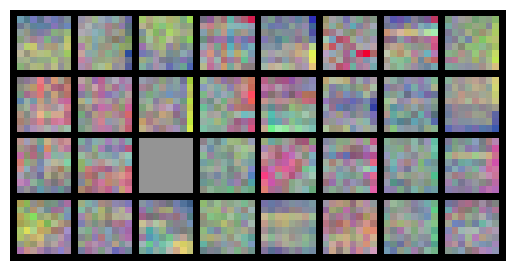

In [4]:
def visualize_weights(weights, nrow=8, padding=1):
    weights = weights.data.clone().permute(0, 1, 3, 2)
    weights_normalized = (weights - weights.min()) / (weights.max() - weights.min())
    weights_grid = make_grid(weights_normalized, nrow=nrow, padding=padding)
    plt.imshow(weights_grid.permute(1, 2, 0).cpu().numpy())
    plt.axis('off')
    plt.show()

conv1_weights = model.feature_extractor[0].weight
print(conv1_weights.shape)
visualize_weights(conv1_weights)

In [5]:
samples = 5000
env_steps = Concept.load_concept_data()
observations = [step.observation for step in random.sample(env_steps, samples)]
observations = np.array(observations)
observations = torch.from_numpy(observations).float()
print(observations.shape)

pygame 2.6.0 (SDL 2.28.4, Python 3.10.12)
Hello from the pygame community. https://www.pygame.org/contribute.html
torch.Size([5000, 3, 84, 84])


In [6]:
# Pass observations through model
_, activations = model.forward(observations, return_acts=True)
print(len(activations))

10


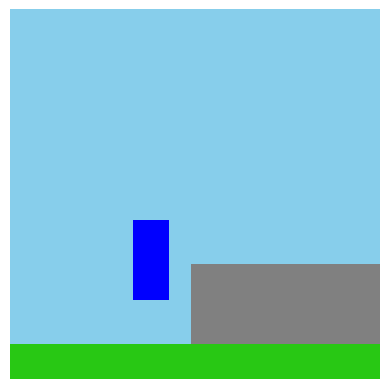

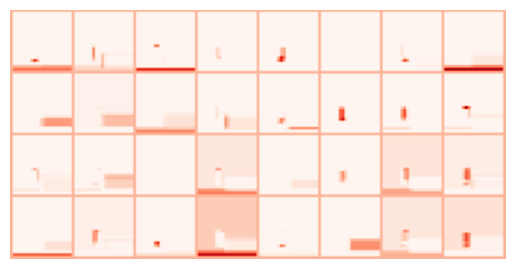

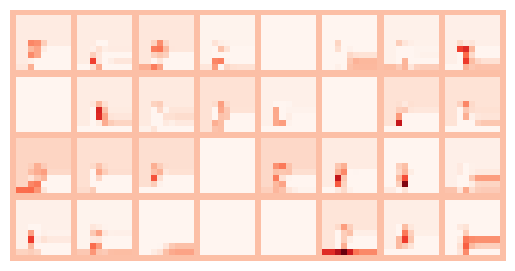

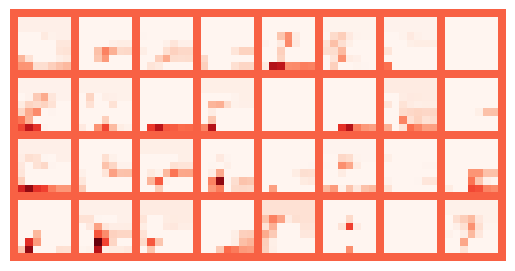

In [7]:
def visualize_activations(activations):
    activations_grid = make_grid(activations.permute(0, 2, 1).unsqueeze(1), nrow=8, padding=1, pad_value=0.5)
    plt.imshow(activations_grid[0], cmap='Reds')
    plt.axis('off')
    plt.show()

example_idx = 22
example_obs = observations[example_idx].permute(2, 1, 0).cpu().numpy()
example_obs = (example_obs - example_obs.min()) / (example_obs.max() - example_obs.min())
plt.imshow(example_obs)
plt.axis('off')
plt.show()
    
acts1 = activations[1]
visualize_activations(acts1[example_idx])
acts3 = activations[3]
visualize_activations(acts3[example_idx])
acts5 = activations[5]
visualize_activations(acts5[example_idx])

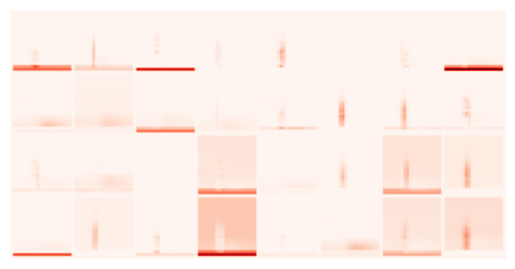

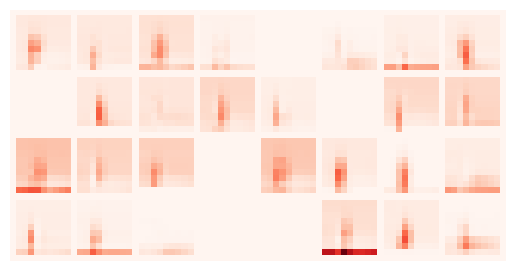

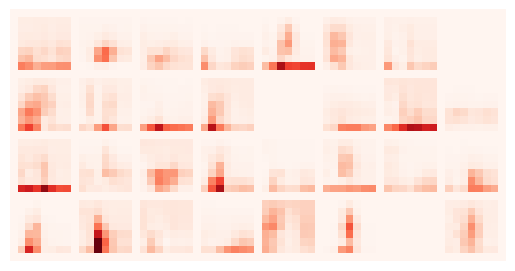

In [8]:
def visualize_mean_activation(activations):
    avg_activation = activations.mean(dim=0)
    avg_activation = (avg_activation - avg_activation.min()) / (avg_activation.max() - avg_activation.min())
    avg_activation_grid = make_grid(avg_activation.permute(0, 2, 1).unsqueeze(1), nrow=8, padding=1, pad_value=0.0)
    plt.imshow(avg_activation_grid[0], cmap='Reds')
    plt.axis('off')
    plt.show()

visualize_mean_activation(acts1)
visualize_mean_activation(acts3)
visualize_mean_activation(acts5)

tensor([1.0249, 0.9976, 0.9029, 0.8941, 0.8869, 0.8585, 0.8190, 0.8028])


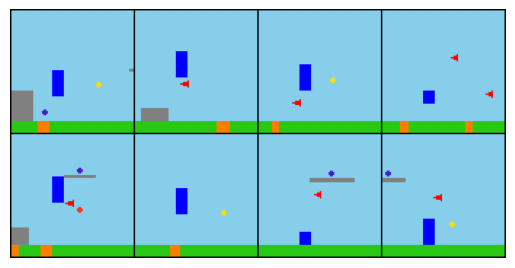

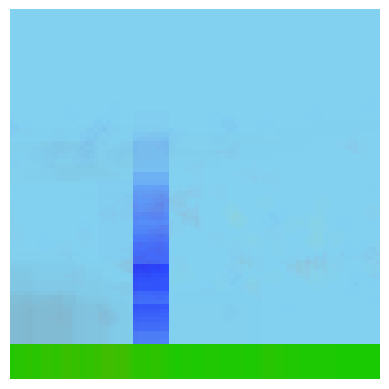

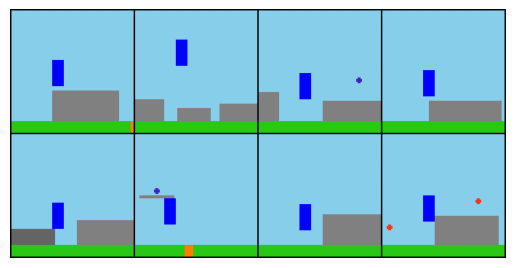

In [15]:
def neuron_triggers(neuron_activations, neuron_idx=0, top_k=8, nrow=4):
    sorted_fc_outputs, sorted_indices = torch.sort(neuron_activations[:, neuron_idx], descending=True)
    top_indices = sorted_indices[:top_k]
    top_indices_10x = sorted_indices[:top_k*10]
    print(sorted_fc_outputs[:top_k])
    
    top_activations = observations[top_indices].permute(0, 1, 3, 2)
    top_activations_10x = observations[top_indices_10x].permute(0, 1, 3, 2)
    top_activations_grid = make_grid(top_activations, nrow=nrow, padding=1, normalize=True)
    plt.imshow(top_activations_grid.permute(1, 2, 0).cpu().numpy())
    plt.axis('off')
    plt.show()
    
    avg_observation = top_activations_10x.mean(dim=0)
    avg_observation = (avg_observation - avg_observation.min()) / (avg_observation.max() - avg_observation.min())
    plt.imshow(avg_observation.permute(1, 2, 0).cpu().numpy())
    plt.axis('off')
    plt.show()
    
    bottom_indices = sorted_indices[-top_k:]
    bottom_activations = observations[bottom_indices].permute(0, 1, 3, 2)
    bottom_activations_grid = make_grid(bottom_activations, nrow=nrow, padding=1, normalize=True)
    plt.imshow(bottom_activations_grid.permute(1, 2, 0).cpu().numpy())
    plt.axis('off')
    plt.show()
    
neuron_idx = 1
acts8 = activations[8]
neuron_triggers(acts8.view(samples, -1), neuron_idx)

(5000, 2)


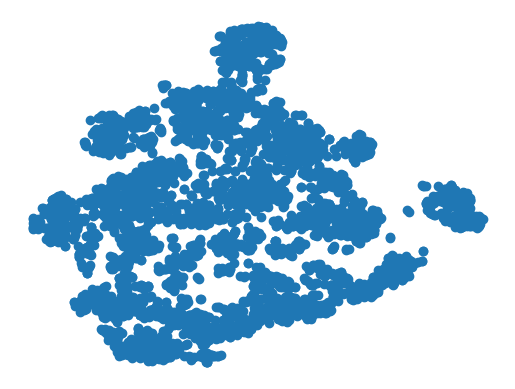

In [10]:
tsne = TSNE(n_components=2)
tsne_outputs = tsne.fit_transform(acts8.view(samples, -1))
print(tsne_outputs.shape)
plt.scatter(tsne_outputs[:, 0], tsne_outputs[:, 1])
plt.axis('off')
plt.show()

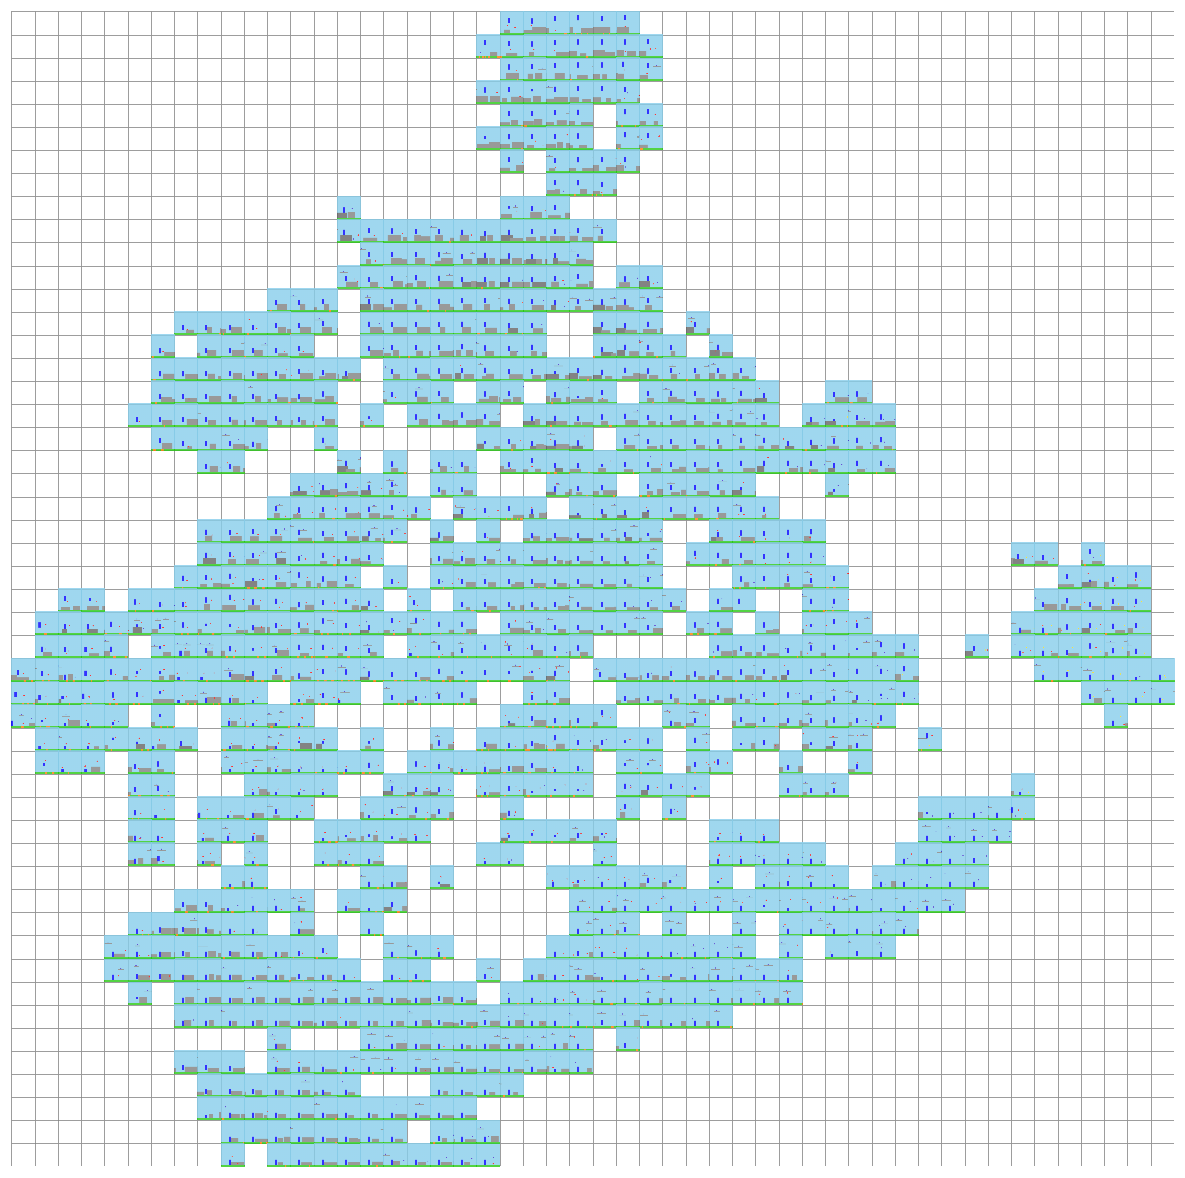

In [20]:
grid_size = 50
image_zoom = 0.2

tsne_min = tsne_outputs.min(axis=0)
tsne_max = tsne_outputs.max(axis=0)
tsne_normalized = (tsne_outputs - tsne_min) / (tsne_max - tsne_min)

grid_indices = np.floor(tsne_normalized * grid_size).astype(int)
grid_indices = np.clip(grid_indices, 0, grid_size - 1)

grid = {}
for idx, (x, y) in enumerate(grid_indices):
    key = (x, y)
    grid.setdefault(key, []).append(idx)

selected_indices = [random.choice(indices) for indices in grid.values()]
images_to_plot = observations[selected_indices]
tsne_subset = tsne_normalized[selected_indices]

def get_image(obs):
    image = obs.permute(2, 1, 0).cpu().numpy()
    image = (image - image.min()) / (image.max() - image.min())
    return OffsetImage(image, zoom=image_zoom, cmap='gray', alpha=0.8)

fig, ax = plt.subplots(figsize=(15, 15))
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

for img, (x_norm, y_norm) in zip(images_to_plot, tsne_subset):
    x_idx = min(int(x_norm * grid_size), grid_size - 1)
    y_idx = min(int(y_norm * grid_size), grid_size - 1)
    
    cell_width = 1.0 / grid_size
    cell_height = 1.0 / grid_size
    img_x = (x_idx + 0.5) * cell_width
    img_y = (y_idx + 0.5) * cell_height
    
    image = get_image(img)
    ab = AnnotationBbox(image, (img_x, img_y), frameon=False, pad=0.1)
    ax.add_artist(ab)

for i in range(grid_size + 1):
    ax.axvline(i / grid_size, color='lightgrey', linewidth=0.5)
    ax.axhline(i / grid_size, color='lightgrey', linewidth=0.5)
    ax.axvline(i / grid_size, color='grey', linewidth=0.5)
    ax.axhline(i / grid_size, color='grey', linewidth=0.5)

plt.axis('off')
plt.show()

In [12]:
components = 10
nmf = NMF(n_components=components, max_iter=5000)
nmf_components = nmf.fit_transform(acts8.view(samples, -1))

Cluster 0


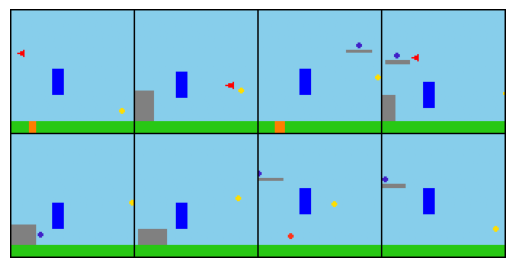

Cluster 1


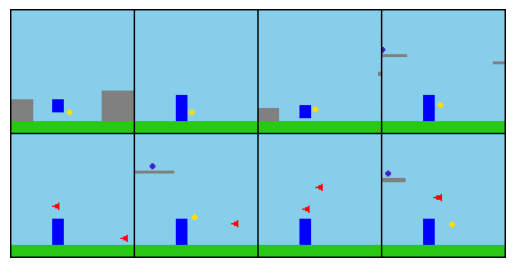

Cluster 2


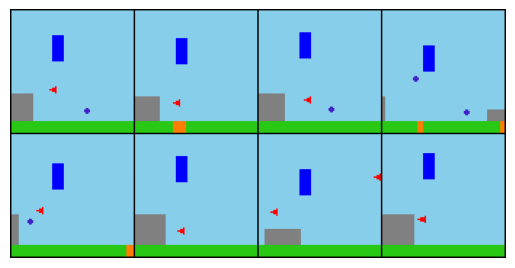

Cluster 3


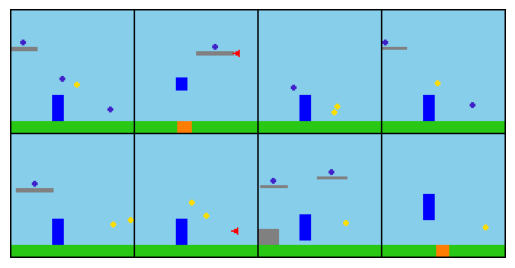

Cluster 4


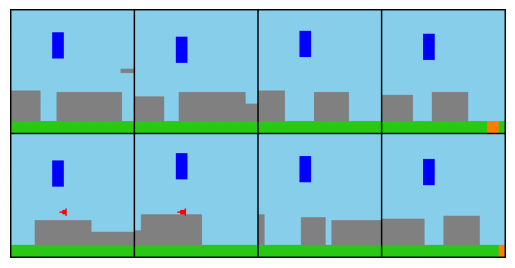

Cluster 5


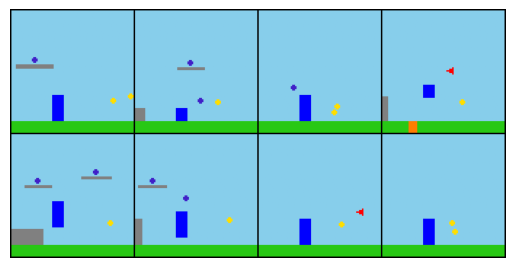

Cluster 6


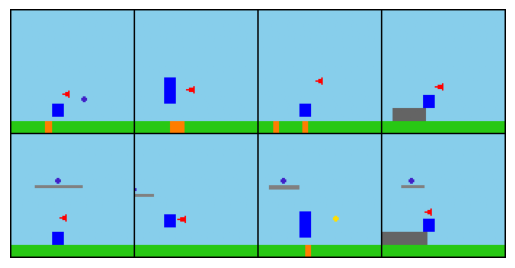

Cluster 7


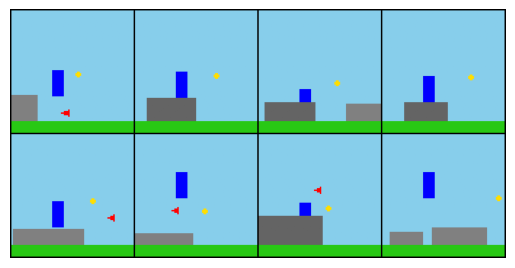

Cluster 8


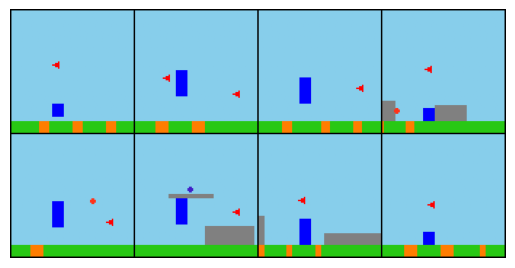

Cluster 9


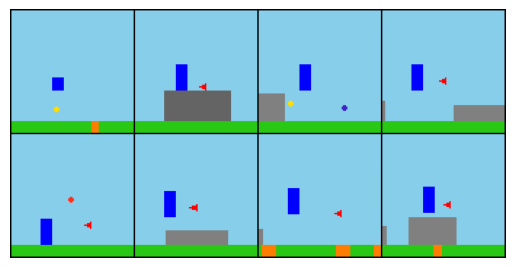

In [13]:
def visualize_nmf_clusters(nmf_components, cluster_idx=4, top_k=8, nrow=4):
    sorted_activations = nmf_components[:, cluster_idx]
    indices = np.argsort(sorted_activations)[::-1]
    top_indices = indices[:top_k]
    
    top_activations = observations[top_indices.copy()].permute(0, 1, 3, 2)
    top_activations_grid = make_grid(top_activations, nrow=nrow, padding=1, normalize=True)
    plt.imshow(top_activations_grid.permute(1, 2, 0).cpu().numpy())
    plt.axis('off')
    plt.show()
    
    '''
    bottom_indices = indices[-top_k:]
    bottom_activations = observations[bottom_indices.copy()].permute(0, 1, 3, 2)
    bottom_activations_grid = make_grid(bottom_activations, nrow=nrow, padding=1, normalize=True)
    plt.imshow(bottom_activations_grid.permute(1, 2, 0).cpu().numpy())
    plt.axis('off')
    plt.show()
    '''

for cluster_idx in range(components):
    print(f"Cluster {cluster_idx}")
    visualize_nmf_clusters(nmf_components, cluster_idx)